based on: https://github.com/essentialsofparallelcomputing/Chapter3/blob/master/JupyterNotebook/HardwarePlatformCharaterization.ipynb

## Operator Benchmark on Gauss3

### Theoretical Parameters

In [1]:
Sockets=2
ProcessorFrequency=2.35
ProcessorCores=64
Hyperthreads=2
VectorWidth=256
WordSizeBits=64
FMA=2

In [2]:
DataTransferRate=3200
MemoryChannels=8
BytesTransferredPerAccess=8

In [3]:
TheoreticalMaximumFlops=Sockets*ProcessorCores*Hyperthreads*ProcessorFrequency*VectorWidth/WordSizeBits*FMA
TheoreticalMemoryBandwidth=Sockets*DataTransferRate*MemoryChannels*BytesTransferredPerAccess/1000
TheoreticalMachineBalance=TheoreticalMaximumFlops/TheoreticalMemoryBandwidth

### Benchmark data

#### Previous Versions

based on:
* `src_master_thesis/optimization/00_unoptimized/exe_op_bench_likwid-perfctr_gauss3_linear_stencil.out`
* `src_master_thesis/optimization/01_compiler_optimized/exe_op_bench_linear_stencil_likwid-perfctr_gauss3.out`
* 
* 
* `src_master_thesis/optimization/00_unoptimized/exe_op_bench_linear_stencil_likwid-perfctr_gauss3.out`
* `src_master_thesis/optimization/00_unoptimized/exe_op_bench_linear_stencil_vcl_likwid-perfctr_gauss3.out`

In [4]:

FLOPS_apply = [
    1.0653186,
    4.1038111,
    5.1812428,
    4.2049185
]
AI_apply = [
    0.0296,
    0.0884,
    0.1145,
    0.1199455409875806
]
labels_apply = [
    "00_stencil_unoptimized",
    "01_stencil_compiler_optimized",
    "03_stencil_vcl_vectorization",
    "04_stencil_tiling"
]

#### Current Versions

In [5]:
import csv

def read_Results(p_path):
    with open(p_path, 'r') as f:
        reader = csv.reader(f)
        #
        # NOTE skip the header
        #
        next(reader, None)
        for row in reader:
            #
            # NOTE select row
            #
            if row[3] == 'apply':
                performance = float(row[8])
                memory_bandwidth = float(row[9])
                break
    result = {
        #
        # NOTE MFLOP/s => GFLOP/s
        #
        'flops': performance/1000,
        'ai': performance/memory_bandwidth
    }
    return result

In [6]:
results = read_Results('./e_linear_stencil_para_likwid_roofline_gauss3.csv')

print(results)

FLOPS_apply.append(results['flops'])
AI_apply.append(results['ai'])
labels_apply.append('05_openmp_stencil_para')

{'flops': 233.9369645, 'ai': 1.61640489219573}


OrderedDict([('tab:blue', '#1f77b4'), ('tab:orange', '#ff7f0e'), ('tab:green', '#2ca02c'), ('tab:red', '#d62728'), ('tab:purple', '#9467bd'), ('tab:brown', '#8c564b'), ('tab:pink', '#e377c2'), ('tab:gray', '#7f7f7f'), ('tab:olive', '#bcbd22'), ('tab:cyan', '#17becf')])
['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']


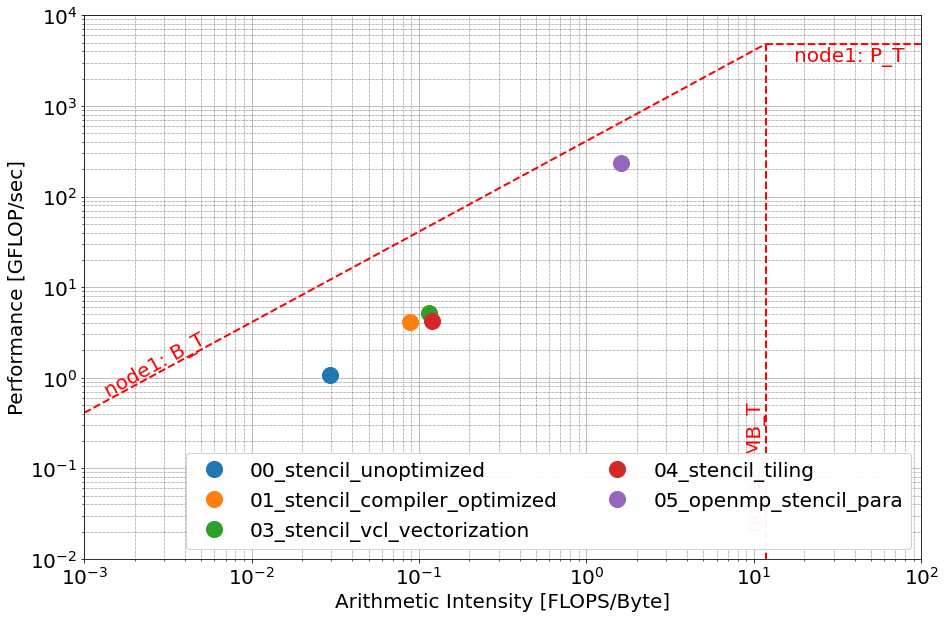

In [7]:
# # Install a pip package in the current Jupyter kernel
# import sys
# !{sys.executable} -m pip install matplotlib
# !{sys.executable} -m pip install numpy

# %matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

print(mcolors.TABLEAU_COLORS)

font = { 'size'   : 20}
plt.rc('font', **font)

markersize = 16
# colors = ['b','g','r','y','m','c']
colors = list(mcolors.TABLEAU_COLORS.values())
print(colors)
styles = ['o','s','v','^','D',">","<","*","h","H","+","1","2","3","4","8","p","d","|","_",".",","]

roofline_color = 'r'

fig = plt.figure(1,figsize=(15,10))
plt.clf()
ax = fig.gca()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Arithmetic Intensity [FLOPS/Byte]')
ax.set_ylabel('Performance [GFLOP/sec]')
ax.grid()
ax.grid(which='minor', linestyle=':', linewidth=0.5, color='black')

nx = 10000
xmin = -3
xmax = 2
ymin = 0.01
ymax = 10000

ax.set_xlim(10**xmin, 10**xmax)
ax.set_ylim(ymin, ymax)

ixx = int(nx*0.02)
xlim = ax.get_xlim()
ylim = ax.get_ylim()

scomp_x_elbow = [] 
scomp_ix_elbow = [] 
smem_x_elbow = [] 
smem_ix_elbow = [] 

x = np.logspace(xmin,xmax,nx)

#
# rooflines
#
for ix in range(1,nx):
    if TheoreticalMemoryBandwidth * x[ix] >= TheoreticalMaximumFlops and TheoreticalMemoryBandwidth * x[ix-1] < TheoreticalMaximumFlops:
        theoMem_ix_elbow = ix-1
        break
for ix in range(1,nx):
    if (TheoreticalMaximumFlops <= TheoreticalMemoryBandwidth * x[ix] and TheoreticalMaximumFlops > TheoreticalMemoryBandwidth * x[ix-1]):
        theoFlops_ix_elbow = ix-1
        break
y = np.ones(len(x)) * TheoreticalMaximumFlops
ax.plot(x[theoFlops_ix_elbow:],y[theoFlops_ix_elbow:],c=roofline_color,ls='--',lw='2')
ax.text(x[-ixx],TheoreticalMaximumFlops*0.95,
    'node1: P_T',
    horizontalalignment='right',
    verticalalignment='top',
    c=roofline_color)
y = x * TheoreticalMemoryBandwidth  
ax.plot(x[:theoMem_ix_elbow+1],y[:theoMem_ix_elbow+1],c=roofline_color,ls='--',lw='2')
ang = np.arctan(np.log10(xlim[1]/xlim[0]) / np.log10(ylim[1]/ylim[0]) 
    * fig.get_size_inches()[1]/fig.get_size_inches()[0] )
ax.text(x[ixx],x[ixx]*TheoreticalMemoryBandwidth*(1+0.25*np.sin(ang)**2),
    'node1: B_T',
    horizontalalignment='left',
    verticalalignment='bottom',
    rotation=180/np.pi*ang,
    c=roofline_color)
plt.vlines(TheoreticalMachineBalance, 0, TheoreticalMaximumFlops, colors=roofline_color, linestyles='dashed', linewidth=2)
ax.text(TheoreticalMachineBalance,2*ymin,
    'node1: MB_T',
    horizontalalignment='right',
    verticalalignment='bottom',
    rotation=90,
    c=roofline_color)

marker_handles = list()
for i in range(0,len(AI_apply)):
  ax.plot(float(AI_apply[i]),float(FLOPS_apply[i]),c=colors[i],marker=styles[0],linestyle='None',ms=markersize,label=labels_apply[i])
  marker_handles.append(ax.plot([],[],c=colors[i],marker=styles[0],linestyle='None',ms=markersize,label=labels_apply[i])[0]) 

leg1 = plt.legend(handles = marker_handles,loc=4, ncol=2)
ax.add_artist(leg1)

# plt.savefig('roofline.png')
# plt.savefig('roofline.eps')
# plt.savefig('roofline.pdf')
# plt.savefig('roofline.svg')

plt.show()